# LoC Data Package Tutorial: Digitized Telephone Directories Data Package

This notebook will demonstrate basic usage of using Python for interacting with [data packages from the Library of Congress](https://data.labs.loc.gov/packages/) via the [Digitized Telephone Directories Data Package](https://data.labs.loc.gov/telephone/) which is derived from the Library's [U.S. Telephone Directory Collection](https://www.loc.gov/collections/united-states-telephone-directory-collection/). We will:

1. [Output a summary of the contents of this data package](#Output-data-package-summary)
2. [Read and query metadata from a data package](#Query-the-metadata-in-a-data-package)
3. [Download full text files and visualize it](#Download-full-text-files-and-visualize-it)

## Prerequisites

In order to run this notebook, please follow the instructions listed in [this directory's README](https://github.com/LibraryOfCongress/data-exploration/blob/master/Data%20Packages/README.md).

## Output data package summary

First we will output a summary of the [Digitized Telephone Directories Data Package](https://data.labs.loc.gov/telephone/) contents

In [1]:
import io

import pandas as pd                     # for reading, manipulating, and displaying data
import requests

from helpers import get_file_stats

DATA_URL = 'https://data.labs.loc.gov/telephone/' # Base URL of this data package

# Download the file manifest
file_manifest_url = f'{DATA_URL}manifest.json'
response = requests.get(file_manifest_url, timeout=60)
response_json = response.json()
files = [dict(zip(response_json["cols"], row)) for row in response_json["rows"]] # zip columns and rows

# Convert to Pandas DataFrame and show stats table
stats = get_file_stats(files)
pd.DataFrame(stats)

,FileType,Count,Size
0,.txt,486,2.37GB


## Query the metadata in a data package

Next we will download a data package's metadata, print a summary of the items' subject values, then filter by a particular location.

All data packages have a metadata file in .json and .csv formats. Let's load the data package's `metadata.json` file:

In [2]:
metadata_url = f'{DATA_URL}metadata.json'
response = requests.get(metadata_url, timeout=60)
data = response.json()
print(f'Loaded metadata file with {len(data):,} entries.')

Loaded metadata file with 3,511 entries.


Next let's convert to pandas DataFrame and print the available properties

In [3]:
df = pd.DataFrame(data)
print(', '.join(df.columns.to_list()))

Date_text, Date, Digitized, Id, IIIF_manifest, Preview_url, Call_number, Type_of_resource, Genre, Location_text, Original_format, Repository, Rights, Source_collection, Title, Mime_type, Online_format, Part_of, Number_of_files, Shelf_id, Url, Last_updated_in_api, Language, Location, Location_ocr


Next print the top 10 most frequent Locations in this dataset

In [4]:
# Since "Locations" are a list, we must "explode" it so there's just one location per row
# We convert to DataFrame so it displays as a table
df['Location_text'].explode().value_counts().iloc[:10].to_frame()

,Location_text
United States -- Illinois -- Chicago,131
United States -- Pennsylvania -- Philadelphia,113
United States -- California -- Los Angeles Central Area,97
United States -- Alabama -- Birmingham,74
United States -- California -- Oakland,74
United States -- California -- San Francisco,71
United States -- Maryland -- Baltimore,63
United States -- California -- Sacramento,51
United States -- California -- San Diego County,47
United States -- Georgia -- Atlanta,46


Now we filter the results to only those items with Location "United States -- Alabama -- Birmingham"

In [5]:
df_by_location = df.explode('Location_text')
subset = df_by_location[df_by_location.Location_text == 'United States -- Alabama -- Birmingham']
print(f'Found {subset.shape[0]:,} items with location "United States -- Alabama -- Birmingham"')

Found 74 items with location "United States -- Alabama -- Birmingham"


## Download full text files and visualize it

First we merge the subset with the text files from the manifest

In [6]:
df_files = pd.DataFrame(files) # Convert file manifest to DataFrame
subset_with_text = pd.merge(df_files, subset, left_on='item_id', right_on='Id', how='inner')
print(f'Found {subset_with_text.shape[0]:,} Birmingham items with text files')

Found 74 Birmingham items with text files


Next we load the OCR text

In [7]:
text = ''
for i, row in subset_with_text.iterrows():
    file_url = f'https://{row["object_key"]}'
    response = requests.get(file_url, timeout=60)
    text += response.text
    text += '\n'
print(f"Loaded text string of length {len(text):,}")

Loaded text string of length 308,204,743


And clean up the text by removing non-words

In [8]:
import re

whitespace_pattern = re.compile(r"\s+")
nonword_pattern = re.compile(r" [\S]*[\\\^<>]+[\S]* ")
tinyword_pattern = re.compile(r" [\S][\S]?[\S]? ")
text = text.replace('\\n', '')
text = whitespace_pattern.sub(" ", text).strip()
text = nonword_pattern.sub(" ", text)
text = tinyword_pattern.sub(" ", text)
text = whitespace_pattern.sub(" ", text).strip()
print(text[:100])

LIBRARY CONGRESS PRESERVATION MICROFILMING PROGRAM MATERIAL WHICH FOLLOWS FROM COMBINED COLLECTIONS 


Finally generate a wordcloud using the text

(-0.5, 399.5, 199.5, -0.5)

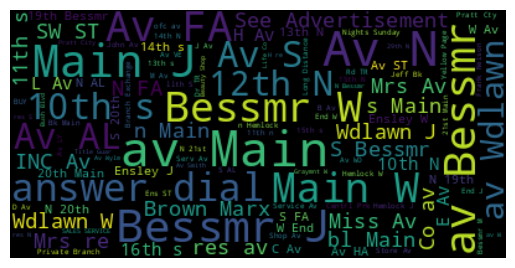

In [9]:
import matplotlib.pyplot as plt         # for displaying data
from wordcloud import WordCloud

# Generate a word cloud image
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")